## Spring 2019 Semester Project 
<b>Computer Vision </b> <br>
<b>Name:</b> Dieu My Nguyen <br>
<b>Project:</b> Detection of honey bees in dense environment

The goal of this project is to apply computer vision techniques to detect honey bees from my research data. The data is videos that need preprocessing. For each frame of a video, a image processing will be applied to crop unnecessary parts of the frame, correct uneven illumination, and detect single bees as best as possible. The mesh cage on the top right is where the queen is. Once bees are detected, we will calculate the average distance of all bees to the queen (center of cage). The eventual goal (past the scope of this class project) would be sufficient detection to perform tracking of individual bees over frames to gain some biological insights.

A raw frame looks like this:

<img src="test_bees_pre.png" alt="" width="50%"/>

We'll crop to leave out some dense clusters on the bottom left to perform this first pipeline for detection. A cleaned up frame ready for bee detection looks like this:

<img src="test_bees.png" alt="" width="40%"/>

Approximately 320 bees are in this image. This number is one measure to check the performance of the detection, although we also need to consider if individual bees are correctly, and not groups of bees or other objects. Bees are in clusters are the greatest difficulty to separate out, given that we use backlighting to record these videos and bees are shown more as silhouettes, making it difficult to detect individuals when their bodies touch or overlap. 

This notebook walks through the pipeline for a first pass at image clean up/processing and detection of honey bees.

### Imports

In [262]:
import os
import sys
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

import config

# Import Python files of low-level implementations
import modules.image_processing as image_processing
import modules.visualization as visualization
import modules.utils as utils
import modules.pipeline as pipeline

In [263]:
# When modules/ notebooks are changes, run to reload into this notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load parameters

In [264]:
processing_params = pipeline.load_config()
processing_params

{'SINGLE_BEE_AREA_THRESHOLD': 1200,
 'BEE_AREA_PERCENTILE': 83,
 'LOCAL_THRESHOLDING': False,
 'GLOBAL_CROP': True,
 'RECURSE_THRESHOLDING': 'global',
 'NUM_RECURSIONS': 10,
 'MAX_FACTOR': 0.15,
 'GLOBAL_TRHESHOLD': 70,
 'RECURSE_GLOBAL_THRESHOLD': 40,
 'NON_MAX_SUPRESSION': False,
 'NMS_THRESHOLD': 0.99,
 'MOROPHOLOGY_TRANSFORM': 'erode'}

### Choose video

Choose a video from data path to perform image processing and bee detection on.

In [7]:
video_path, video_name = pipeline.video_selection()

Dataset Dirs
------------
0. /Users/dieumynguyen/Documents/Datasets/Bees/src_data
Dataset dir: 0
'/Users/dieumynguyen/Documents/Datasets/Bees/src_data' selected.
Video Paths
------------
0. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/2019-03-30_QueenStationary_HighDensity_3.MP4
1. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/2019-03-30_QueenStationary_HighDensity_2.MP4
2. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/test_1.mp4
3. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/2018-09-22_QueenStationary1.mp4
4. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/test_3.mp4
5. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/2019-03-30_QueenStationary_HighDensity_1.MP4
6. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/test_2.mp4
7. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/C0014.MP4
8. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/test_5.mp4
9. /Users/dieumynguyen/Documents/Datasets/Bees/src_data/test_4.mp4
10. /Users/dieumynguy

Load video data using VideoHandler class from utils notebook. 

In [8]:
vid = utils.VideoHandler(video_path) 

### Preview Image

Clean up uneven background illumination. Showing preview for 1 frame of video.

In [9]:
# Label the queen with red dot
QUEEN_X = 2580
QUEEN_Y = 500

SLICE_R = slice(None, None) # Default None, None -> see full image
SLICE_C = slice(None, None) # Default None, None -> see full image

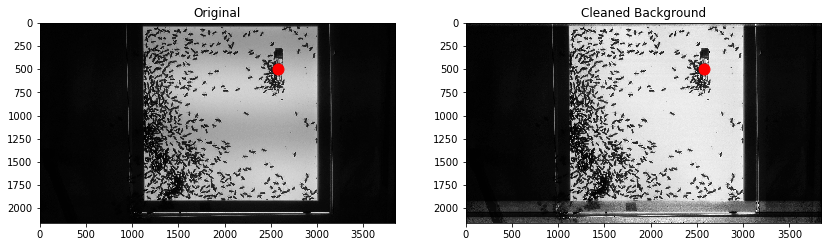

In [10]:
img, cleaned_img = pipeline.preview_video_img(video_path, SLICE_R, SLICE_C, QUEEN_X, QUEEN_Y, remove_background_lines=True);

Save original or cleaned image if wanted.

In [11]:
im = Image.fromarray(img)
im.save("test_bees_pre.png")

### Preview Slice Selection

We can also crop out unwanted areas of the frame by specifying where to slice by row and column.

In [12]:
QUEEN_X = 1280
QUEEN_Y = 450

SLICE_R = slice(40, 1600)        # User specifies row crop
SLICE_C = slice(1300, 1300+1560) # User specifies column crop

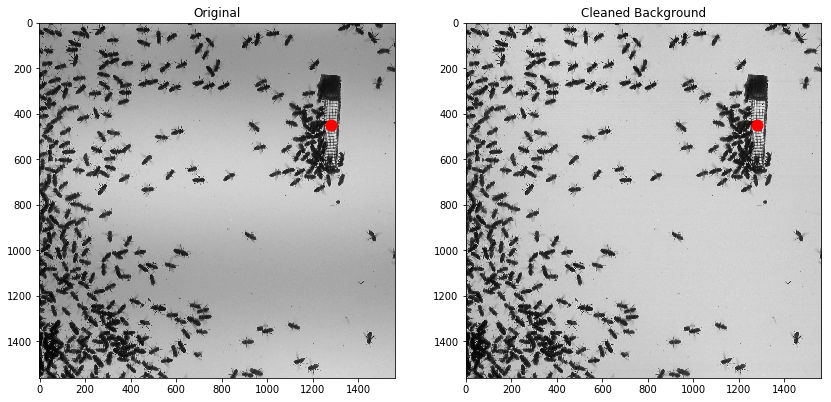

In [13]:
img, cleaned_img = pipeline.preview_video_img(video_path, SLICE_R, SLICE_C, QUEEN_X, QUEEN_Y, remove_background_lines=True)

### Preview Otsu vs global thresholding

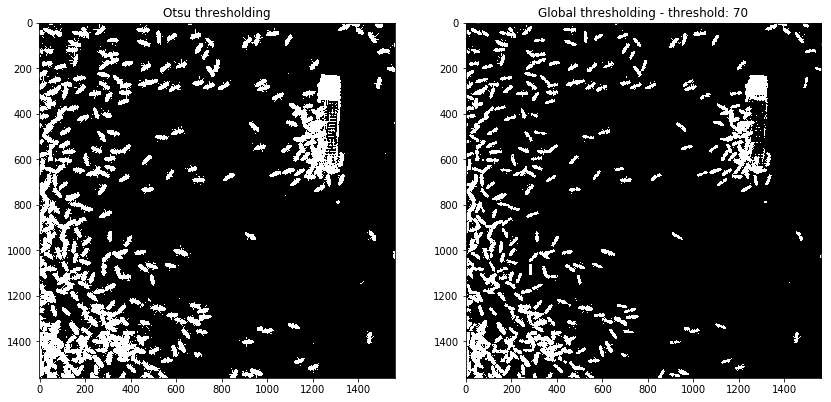

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14,14))

otsu_threshold = image_processing.otsu_thresholding(cleaned_img)
global_threshold = image_processing.global_thresholding(cleaned_img, processing_params["GLOBAL_TRHESHOLD"])

# Convert T and F to 1 and 0
otsu_threshold = (otsu_threshold * 1).astype('uint8')
global_threshold = (global_threshold * 1).astype('uint8')

ax[0].imshow(otsu_threshold, cmap=config.GRAY_CMAP)
ax[0].set_title("Otsu thresholding")
ax[1].imshow(global_threshold, cmap=config.GRAY_CMAP)
ax[1].set_title(f"Global thresholding - threshold: {processing_params['GLOBAL_TRHESHOLD']}");

### Preview morphological transforms

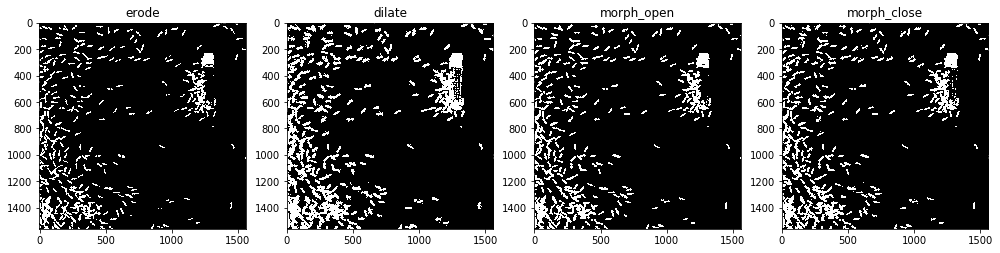

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(17, 17))

transforms = ["erode", "dilate", "MORPH_OPEN", "MORPH_CLOSE"]

for t_i, t in enumerate(transforms):
    img_transformed = image_processing.morphology_transform(global_threshold, t)
    ax[t_i].imshow(img_transformed, cmap=config.GRAY_CMAP)
    ax[t_i].set_title(t.lower());

### Begin detecting bees in defined number of frames (default=25)

In [265]:
all_bees = pipeline.process_video(video_path, SLICE_R, SLICE_C, processing_params)

Image 31

In [266]:
overlay_imgs, overlay_img_srcs = pipeline.process_overlay_imgs(video_path, SLICE_R, SLICE_C, QUEEN_X, QUEEN_Y,
                                                               all_bees, processing_params, config)

Image 31

Save first frame to show in report...

In [268]:
overlay_img = overlay_imgs[0][:,:,::-1]
plt.figure(dpi=400)
plt.axis('off')
plt.imshow(overlay_img)
plt.savefig("imgs/img.png", bbox_inches='tight', transparent=True, pad_inches=0)
plt.close()

### Write video showing detections overlayed on frame

Sample output frame with yellow dots indicating centroids of bees' bounding boxes and some stats showing number of detections and average bee distance from the queen cage:

<img src="imgs/1.png" alt="" width="70%"/>

In [269]:
video_out_dir, video_out_path, new_video_num = pipeline.setup_video_save(video_name)
print(f"video_out_dir: {video_out_dir}")
print(f"video_out_path: {video_out_path}")
print(f"new_video_num: {new_video_num}")

video_out_dir: processed_vids/test_5
video_out_path: processed_vids/test_5/test_5__processed_008.mp4
new_video_num: 8


In [270]:
config_path = os.path.join(video_out_dir, f"config_{new_video_num:03d}")
print(f"config_path: {config_path}")

config_path: processed_vids/test_5/config_008


In [272]:
# Write Video
print(f"Writing overlay images as video to '{video_out_path}'")
frame_interval = 1
utils.imgs2vid(overlay_imgs, video_out_path, frame_interval=1)

# Save Config
pipeline.save_config(config_path, processing_params)

Writing overlay images as video to 'processed_vids/test_5/test_5__processed_008.mp4'
